In [1]:
using Revise
using Rocket
using ReactiveMP
using GraphPPL
using Distributions
using LinearAlgebra
import ProgressMeter
using WAV
using Plots

In [2]:
include("helpers/aida_segmentation.jl")
include("helpers/aida_snr.jl")
include("helpers/aida_ar.jl")
include("models_inferences.jl")

batch_coupled_learning (generic function with 1 method)

In [12]:
# priors
bmθ = [1.25231, -0.424707]
bvθ = [0.0074575971735365044 -0.005614127136793097; -0.005614127136793097 0.006163152988713943]
bγ  = [41.0, 0.1]

2-element Vector{Float64}:
 41.0
  0.1

In [4]:
# speech_bar, fs = wavread("sound/mixed/bar_speech.wav")
speech_bar, fs = wavread("sound/NOIZEUS/train_noise/0dB/sp03_train_sn0.wav")
sb_seg = get_frames(speech_bar, fs)

300×80 Matrix{Float64}:
 -0.0222175    -0.0467238   -0.0191351   …  -0.0410169   -0.0402539
 -0.0678426    -0.0908841   -0.00866726     -0.0505997    0.00778222
 -0.023133      0.00997955  -0.0314951      -0.0216376    0.00769066
  0.0735496     0.0426649    0.0250862       0.0120548   -0.0406507
 -0.0400403     0.015656    -0.0166936      -0.0409864   -0.0286569
 -0.0658589    -0.015656    -0.00634785  …  -0.0433973   -0.0110782
 -0.00375378    0.00909452   0.0137028       0.00427259   0.0199286
 -0.0314341    -0.0239875   -6.1037e-5       0.00384533   0.063509
 -0.000366222   0.0135197    0.0160222      -0.0294198    0.00735496
 -0.0213019     0.0127873    0.0208136      -0.0234382   -0.000793481
 -0.0753197    -0.0367748    0.0145878   …  -0.0260628    0.00717185
 -0.000854518   0.0169683    0.0318613       0.00128178  -0.00314341
  0.0467849    -0.0152898    0.00161748      0.00219733   0.0213935
  ⋮                                      ⋱               
  0.0292367    -0.0217292   

In [13]:
# obtaining prior for BAR
totseg = size(sb_seg, 1)
ar_order = 2
rmθ = zeros(totseg, ar_order)
rvθ = zeros(totseg, ar_order, ar_order)
for segnum in 1:totseg
    rmθ[segnum, :], rvθ[segnum, :, :] = bmθ, bvθ
end
priors_eta = rmθ, rvθ
priors_tau = [(bγ[1], bγ[2]) for _ in 1:totseg]

300-element Vector{Tuple{Float64, Float64}}:
 (41.0, 0.1)
 (41.0, 0.1)
 (41.0, 0.1)
 (41.0, 0.1)
 (41.0, 0.1)
 (41.0, 0.1)
 (41.0, 0.1)
 (41.0, 0.1)
 (41.0, 0.1)
 (41.0, 0.1)
 (41.0, 0.1)
 (41.0, 0.1)
 (41.0, 0.1)
 ⋮
 (41.0, 0.1)
 (41.0, 0.1)
 (41.0, 0.1)
 (41.0, 0.1)
 (41.0, 0.1)
 (41.0, 0.1)
 (41.0, 0.1)
 (41.0, 0.1)
 (41.0, 0.1)
 (41.0, 0.1)
 (41.0, 0.1)
 (41.0, 0.1)

In [6]:
function agent_weigths(sources_num)
    w = zeros(sources_num); w[1] = 1.0
    return w
end

agent_weigths (generic function with 1 method)

In [14]:
function HA_algorithm(segments, priors_η, priors_τ, ar_1_order, ar_2_order, vmp_its)
    totseg = size(segments, 1)
    l      = size(segments, 2)
    rmx = zeros(totseg, l)
    rvx = zeros(totseg, l)
    rmθ = zeros(totseg, ar_1_order)
    rvθ = zeros(totseg, ar_1_order, ar_1_order)
    rγ = fill(tuple(.0, .0), totseg)
    
    rmz = zeros(totseg, l)
    rvz = zeros(totseg, l)
    rmη = zeros(totseg, ar_2_order)
    rvη = zeros(totseg, ar_2_order, ar_2_order)
    rτ = fill(tuple(.0, .0), totseg)
    
    fe  = zeros(totseg, vmp_its)
    
    rmo= zeros(totseg, l)
    
    ProgressMeter.@showprogress for segnum in 1:totseg
        # get weights
        weights                           = agent_weigths(2)
        prior_η                           = (priors_η[1][segnum, :], priors_η[2][segnum, :, :])
        prior_τ                           = priors_τ[segnum]
        γ, θ, zs, τ, η, xs, fe[segnum, :] = coupled_inference(segments[segnum, :], prior_η, prior_τ, ar_1_order, ar_2_order, vmp_its)
        mz, vz                            = mean.(zs), cov.(zs)
        mθ, vθ                            = mean(θ), cov(θ)
        rmz[segnum, :], rvz[segnum, :]    = first.(mz), first.(vz)
        rmθ[segnum, :], rvθ[segnum, :, :] = mθ, vθ
        rγ[segnum]                        = shape(γ), rate(γ)
        
        mx, vx                            = mean.(xs), cov.(xs)
        mη, vη                            = mean(η), cov(η)
        rmx[segnum, :], rvx[segnum, :]    = first.(mx), first.(vx)
        rmη[segnum, :], rvη[segnum, :, :] = mη, vη
        rτ[segnum]                        = shape(τ), rate(τ)
        
        # HA part
        speech = rmz[segnum, :] .* weights[1]
        noise  = rmx[segnum, :] .* weights[2]
        rmo[segnum, :] = speech .+ noise
    end
    rmz, rvz, rmθ, rvθ, rγ, rmx, rvx, rmη, rvη, rτ, fe, rmo
end

HA_algorithm (generic function with 1 method)

In [15]:
rmz, rvz, rmθ, rvθ, rγ, rmx, rvx, rmη, rvη, rτ, fe, rmo = HA_algorithm(sb_seg, priors_eta, priors_tau, 10, 2, 10);

Progress: 100%|█████████████████████████████████████████| Time: 0:02:51


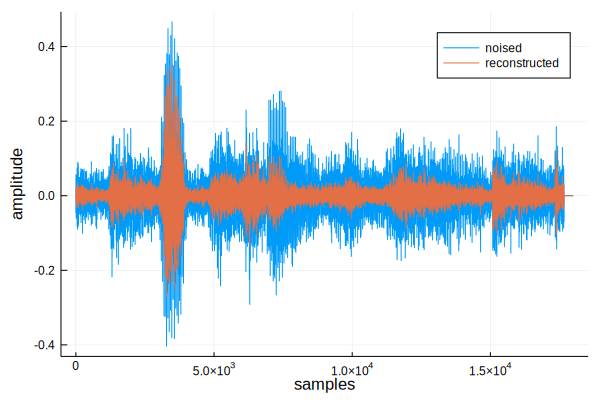

In [16]:
ha_out = get_signal(rmo, fs)
plot(get_signal(sb_seg, fs), label=:noised, ylabel="amplitude", xlabel="samples")
plot!(ha_out, label="reconstructed")

In [17]:
wavwrite(ha_out, fs, "sound/processed/ha_output.wav")

In [18]:
; python3 spectrogram.py

/Users/apodusenko/Documents/Julia/AIDA/spectrogram.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, y = wavfile.read("sound/speech/sp02.wav")
/Users/apodusenko/Documents/Julia/AIDA/spectrogram.py:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, x = wavfile.read("sound/mixed/bar_speech.wav")
